In [1]:
import sys
sys.path.append("./scripts/")
from gridmap import *
import math
import copy
from matplotlib.animation import PillowWriter    #アニメーション保存用
neigbor_grids = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
theta_neigbors = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi, -3 * np.pi / 4, -np.pi / 2, -np.pi / 4])

In [2]:
class BUG():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        if not self.world.start_index == None:
            self.reset()
        
    def reset(self):
        self.grid_pair = []
        self.m_line = []
        self.alongObstacle = False
        self.nextObstacle = []
        self.prev_obs = []
        self.neigbor_obs_cans = []
        self.v = []
        
        self.nowIndex = self.world.start_index
        self.getMLine()
        self.mLine_min = float('inf')
        
    def getMLine(self):
        index = self.world.start_index
        self.m_line.append(index)
        while(index != self.world.goal_index):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            self.m_line.append(next_index)
            index = next_index
      
    def draw(self, ax, elems):
        if(self.world.goal_index == self.nowIndex):
            pass
        else:
            self.nowIndex = self.next(self.nowIndex, ax, elems)
            if(self.world.goal_index != self.nowIndex):
                self.drawGrid(ax, elems, self.nowIndex, "red")

    def next(self, index, ax, elems):
        next_index = None
        next_chk_index = None
        
        # 過去に通過したM-Lineよりも近いM-Lineにに到達した場合
        if(index in self.m_line and self.distance(index, self.world.goal_index) < self.mLine_min):
            self.alongObstacle = False
            next_chk_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_chk_index = list(index + neigbor_grids[neigbor_grid])
            self.mLine_min = self.distance(self.world.goal_index, index)
        
        # 前回，障害物がなかった場合
        if(self.alongObstacle is False):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            if(self.isObstacle(next_index)):
                self.alongObstacle = True
                next_index = self.moveCW(index, next_chk_index)
            else:
                self.mLine_min = self.distance(self.world.goal_index, index)
            self.v = [index[0] - next_index[0], index[1] - next_index[1]]
            return next_index
        
        # 前回接触した障害物に隣接する障害物をリストアップ
        if self.isObstacle([self.prev_obs[0] - self.v[0], self.prev_obs[1] - self.v[1]]):
            next_index = self.moveCW(index, [self.prev_obs[0] - self.v[0], self.prev_obs[1] - self.v[1]])
        else:
            next_index = [self.prev_obs[0] - self.v[0], self.prev_obs[1] - self.v[1]]
            if(abs(next_index[0] - index[0]) == 1 and abs(next_index[1] - index[1]) == 1):
                next_index = [index[0] - self.v[0], index[1] - self.v[1]]
        self.v = [index[0] - next_index[0], index[1] - next_index[1]]
        return next_index
    
    def moveCW(self, index, next_chk_index):# 左回りになるように移動
        dx = index[0] - next_chk_index[0]
        dy = index[1] - next_chk_index[1]
        if((dx == 1 and dy == 0) or (dx == 1 and dy == 1)): # 障害物が左側または左下側の場合，下へ移動する
            if not self.isObstacle([index[0], index[1] - 1]):
                next_index = [index[0], index[1] - 1]
                self.prev_obs = [index[0] -1, index[1]]
            elif not self.isObstacle([index[0] + 1, index[1]]):
                next_index = [index[0] + 1, index[1]]
                self.prev_obs = [index[0], index[1] - 1]
            elif not self.isObstacle([index[0], index[1] + 1]):
                next_index = [index[0], index[1] + 1]
                self.prev_obs = [index[0] + 1, index[1]]
            else:
                next_index = [index[0] - 1, index[1]]
                self.prev_obs = [index[0], index[1] + 1]
        elif((dx == 1 and dy == -1) or (dx == 0 and dy == -1)): # 障害物が左上側または上側の場合，左へ移動する
            if not self.isObstacle([index[0] - 1, index[1]]):
                next_index = [index[0] - 1, index[1]]
                self.prev_obs = [index[0], index[1] + 1]
            elif not self.isObstacle([index[0], index[1] - 1]):
                next_index = [index[0], index[1] - 1]
                self.prev_obs = [index[0] - 1, index[1]]
            elif not self.isObstacle([index[0] + 1, index[1]]):
                next_index = [index[0] + 1, index[1]]
                self.prev_obs = [index[0], index[1] - 1]
            else:
                next_index = [index[0], index[1] + 1]
                self.prev_obs = [index[0] + 1, index[1]]
        elif((dx == -1 and dy == 0) or (dx == -1 and dy == -1)): # 障害物が右側または右上側の場合，上へ移動する
            if not self.isObstacle([index[0], index[1] + 1]):
                next_index = [index[0], index[1] + 1]
                self.prev_obs = [index[0] + 1, index[1]]
            elif not self.isObstacle([index[0] - 1, index[1]]):
                next_index = [index[0] - 1, index[1]]
                self.prev_obs = [index[0], index[1] + 1]
            elif not self.isObstacle([index[0], index[1] - 1]):
                next_index = [index[0], index[1] - 1]
                self.prev_obs = [index[0] - 1, index[1]]
            else:
                next_index = [index[0] + 1, index[1]]
                self.prev_obs = [index[0], index[1] - 1]
        elif((dx == -1 and dy == 1) or (dx == 0 and dy == 1)): # 障害物が下側または左下側の場合，右へ移動する
            if not self.isObstacle([index[0] + 1, index[1]]):
                next_index = [index[0] + 1, index[1]]
                self.prev_obs = [index[0], index[1] - 1]
            elif not self.isObstacle([index[0], index[1] + 1]):
                next_index = [index[0], index[1] + 1]
                self.prev_obs = [index[0] + 1, index[1]]
            elif not self.isObstacle([index[0] - 1, index[1]]):
                next_index = [index[0] - 1, index[1]]
                self.prev_obs = [index[0], index[1] + 1]
            else:
                next_index = [index[0], index[1] + 1]
                self.prev_obs = [index[0] - 1, index[1]]
        return next_index
    
    def drawGrid(self, ax, elems, grid, color, alpha=0.5):
        r = patches.Rectangle(
            xy=((grid[0])*self.world.grid_step[0], (grid[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color=color,
            fill=True,
            alpha=alpha
        )
        #elems.append(ax.add_patch(r))
        ax.add_patch(r)
        
    def isObstacle(self, index):
        if(index[0] > self.world.grid_map.shape[0] - 1 or index[1] > self.world.grid_map.shape[1] - 1 or index[0] < 0 or index[1] < 0):
            return True
        if(self.world.grid_map[index[0]][index[1]] == '0'):
            return True
        else:
            return False
    
    def distance(self, index1, index2):
        dx = index1[0] - index2[0]
        dy = index1[1] - index2[1]
        return np.sqrt(dx**2 + dy**2)

<IPython.core.display.Javascript object>


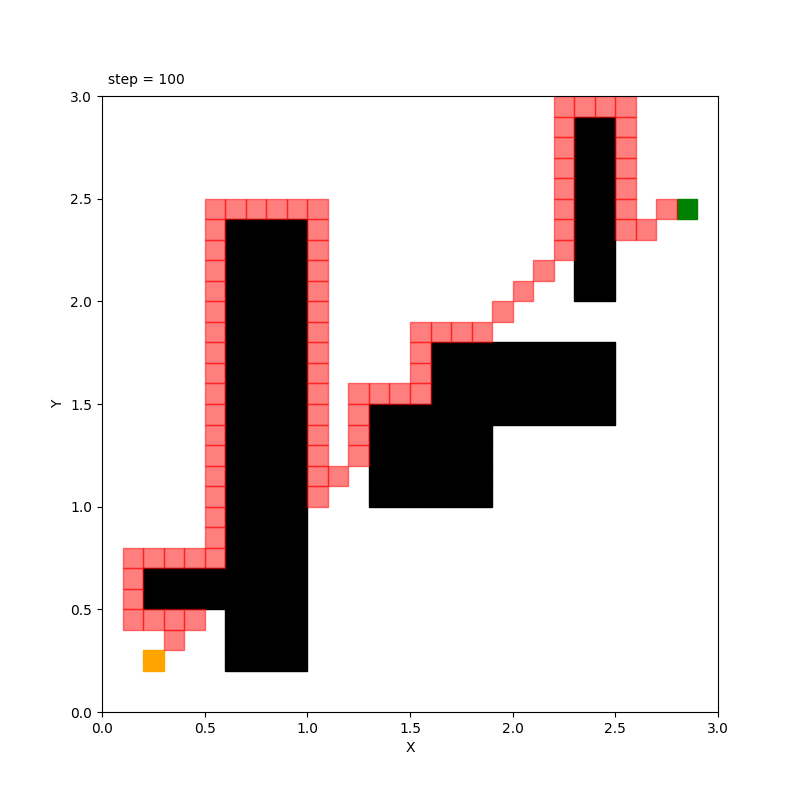

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "./csvmap/map7.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(BUG(world))
    
    world.draw(figsize=(8, 8))
    #world.ani.save('bug_map.gif', writer='pillow', fps=100)    #アニメーション保存